### Курсовая работа

Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error as mae

In [2]:
def make_plot(x, y, df):
    """ Получаем простой график х-у"""
    plt.scatter(df[x], df[y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

In [19]:
def non_num_to_bool (columns, df):
    """ Заменяем объекты на булево значение, если в признаке всего два значения"""
    for column in columns:
        unique_true = df[column].unique()[1]
        df[column]  = df[column] == unique_true

In [38]:
def remove_IQR(column, df):
    """Избавляемся от выбросов, используя межквартильный диапазон. Заменяем выбросы на медиану"""
    IQ=df[column].describe()['75%']-df[column].describe()['25%']
    low_border=df[column].describe()['25%']-IQ*1.5
    high_border=df[column].describe()['75%']+IQ*1.5
    med= df[column].median()
    
    print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n\tMEAN:\t{}'.format(column, IQ, low_border, high_border, med))

    index_to_replace = df[(df[column]<low_border)|(df[column]>high_border)].index

    df.loc[index_to_replace, column] = med
    print('In {} row {} was replaced to {}.'.format(index_to_replace.size, column, med))

In [55]:

def fit_pred(x_train, y_train, x_test, y_test, model):
    """ Считаем метрику r2_score и mae по переданным наборам данных и модели."""
    model.fit(x_train, y_train)
    
    y_train_pred = model.predict(x_train) 
    y_test_pred = model.predict(x_test)
    
    r2_train = r2_score(y_train, y_train_pred)
    mae_train = mae(y_train, y_train_pred)
    print(f'r2_train = {r2_train}, mae_train: {mae_train}')
    
    r2_test = r2_score(y_test, y_test_pred)
    mae_test = mae(y_test, y_test_pred)
    print(f'r2_test = {r2_test}, mae_test: {mae_test}')

In [5]:
df = pd.read_csv('train.csv', encoding='utf-8')
df_test = pd.read_csv('test.csv', encoding='utf-8')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

В наборе данных имеются два признака с пропущенными значениями, а также три категориальных признака. Признак Healthcare почти наполовину пуст, его не будем учитывать. А пустые значения признака LifeSquare заполним медианами.

In [8]:
# отбор числовых колонок
df_numeric = df.select_dtypes(include=[np.number])
print(df_numeric.columns.values)

# отбор категорийных колонок
df_non_numeric = df.select_dtypes(exclude=[np.number])
print(df_non_numeric.columns.values)


['Id' 'DistrictId' 'Rooms' 'Square' 'LifeSquare' 'KitchenSquare' 'Floor'
 'HouseFloor' 'HouseYear' 'Ecology_1' 'Social_1' 'Social_2' 'Social_3'
 'Healthcare_1' 'Helthcare_2' 'Shops_1' 'Price']
['Ecology_2' 'Ecology_3' 'Shops_2']


In [11]:
# уберём полупустой признак
df.drop(['Healthcare_1'], axis=1, inplace=True)



KeyError: "['Healthcare_1'] not found in axis"

In [12]:
# заполним медианами пустые значения признака LifeSquare
med = df['LifeSquare'].median()
print(med)
df['LifeSquare'] = df['LifeSquare'].fillna(med)

32.78126019215574


In [13]:
# посмотрим на категорийные признаки
for column in df_non_numeric.columns.values:
    print('{}\n'.format(df[column].value_counts()))

B    9903
A      97
Name: Ecology_2, dtype: int64

B    9725
A     275
Name: Ecology_3, dtype: int64

B    9175
A     825
Name: Shops_2, dtype: int64



C:\Users\a.shernazarov\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\a.shernazarov\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\a.shernazarov\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn

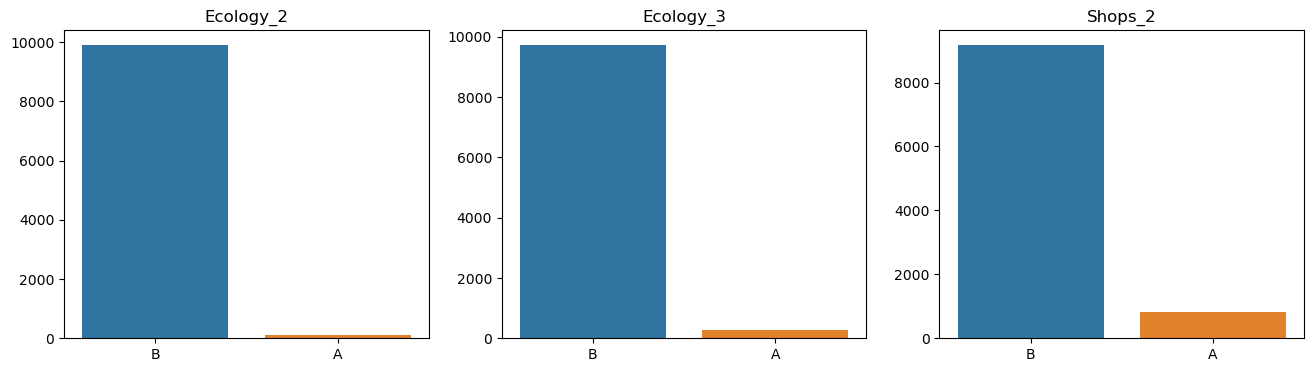

In [18]:
# Нагладно посмотрим на графике:
plt.figure(figsize = (16,4))

for i, colname in enumerate(df_non_numeric.columns.values):
    counts = df[colname].value_counts()
    
    plt.subplot(1,3,i+1)    
    plt.title(colname)
    sns.barplot(counts.index, counts.values)
    
plt.show()

Каждый признак имеет по два значения, заменим их на бинарный тип. 

In [20]:
non_num_to_bool(df_non_numeric.columns.values, df)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  bool   
 11  Ecology_3      10000 non-null  bool   
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  bool   
 18  Price  

In [25]:
# Посмотрим что получилось
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,36.266040,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,76.609981,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,25.527399,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,633233.466570


Большие отклонения по столцам Square, LifeSquare, KitchenSquare, HouseYear. Уберём эти отклонения.

In [39]:
remove_IQR('Square', df)
remove_IQR('LifeSquare', df)
remove_IQR('KitchenSquare', df)
remove_IQR('HouseYear', df)

For column Square
	IQ:	24.125744426186976
	LOW:	5.586264180189367
	HIGH:	102.08924188493728
	MEAN:	52.51330992401352
In 242 row Square was replaced to 52.51330992401352.
For column LifeSquare
	IQ:	15.899834993080137
	LOW:	1.6776461714428557
	HIGH:	65.27698614376341
	MEAN:	32.78126019215574
In 517 row LifeSquare was replaced to 32.78126019215574.
For column KitchenSquare
	IQ:	8.0
	LOW:	-11.0
	HIGH:	21.0
	MEAN:	6.0
In 47 row KitchenSquare was replaced to 6.0.
For column HouseYear
	IQ:	27.0
	LOW:	1933.5
	HIGH:	2041.5
	MEAN:	1977.0
In 38 row HouseYear was replaced to 1977.0.


array([[<AxesSubplot:title={'center':'Id'}>,
        <AxesSubplot:title={'center':'DistrictId'}>,
        <AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>],
       [<AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>,
        <AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>],
       [<AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>,
        <AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>],
       [<AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>,
        <AxesSubplot:title={'center':'Price'}>]], dtype=object)

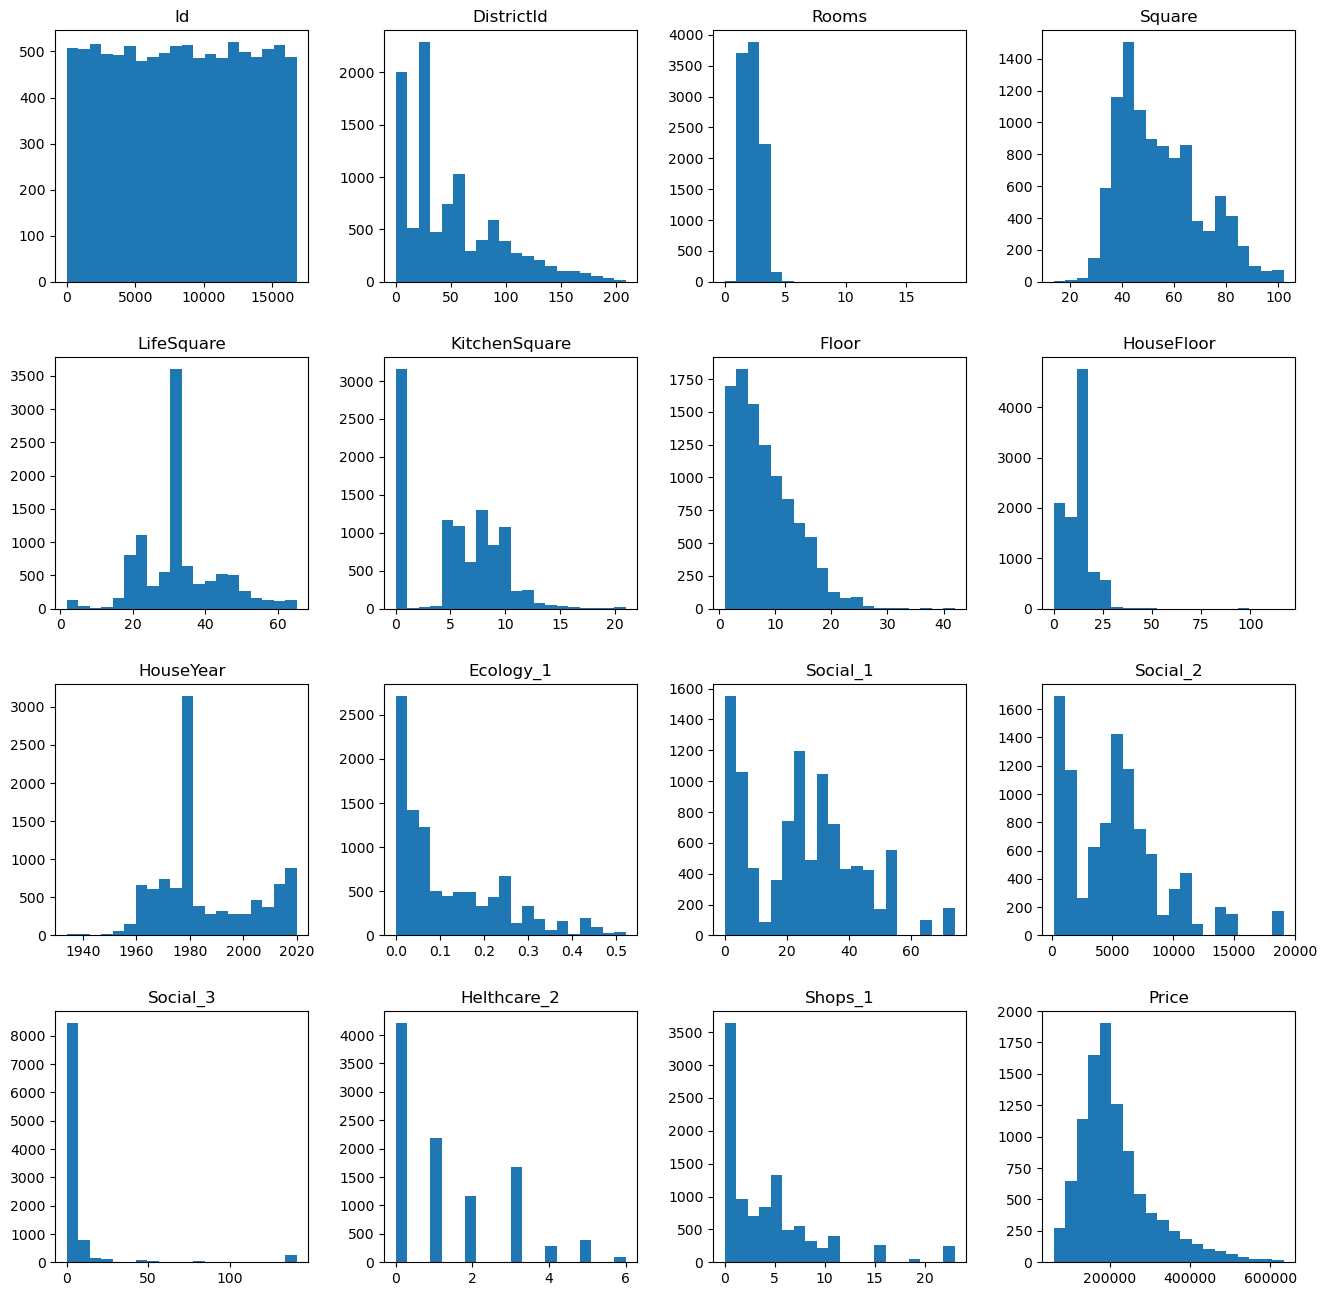

In [40]:
df.hist(figsize=(16,16), bins=20, grid=False)

Теперь поработаем с тестовым файлом

In [44]:
df_test.drop(['Healthcare_1'], axis=1, inplace=True)


KeyError: "['Healthcare_1'] not found in axis"

In [47]:
df_test['LifeSquare'] = df_test['LifeSquare'].fillna(df_test['LifeSquare'].median())
df_test_non_numeric = df_test.select_dtypes(exclude=[np.number])
print(df_test_non_numeric.columns.values)
non_num_to_bool(df_test_non_numeric.columns.values, df_test)

['Ecology_2' 'Ecology_3' 'Shops_2']


In [48]:

remove_IQR('Square', df_test)
remove_IQR('LifeSquare', df_test)
remove_IQR('KitchenSquare', df_test)
remove_IQR('HouseYear', df_test)

For column Square
	IQ:	23.465864129920462
	LOW:	6.72942026475517
	HIGH:	100.59287678443701
	MEAN:	52.92133956284074
In 24 row Square was replaced to 52.92133956284074.
For column LifeSquare
	IQ:	11.218855231701404
	LOW:	9.79161441625303
	HIGH:	54.66703534305864
	MEAN:	32.92508663208161
In 301 row LifeSquare was replaced to 32.92508663208161.
For column KitchenSquare
	IQ:	8.0
	LOW:	-11.0
	HIGH:	21.0
	MEAN:	6.0
In 0 row KitchenSquare was replaced to 6.0.
For column HouseYear
	IQ:	27.0
	LOW:	1932.5
	HIGH:	2040.5
	MEAN:	1977.0
In 0 row HouseYear was replaced to 1977.0.


Разбиваем датасет на тестовый и валидационный

In [49]:
features = df.columns.drop('Id').drop('DistrictId').drop('Price')
target = 'Price'
X = pd.DataFrame(df, columns=features)
y = pd.DataFrame(df, columns=[target])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
X_test = df_test[features]
X_test.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
0,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,False,False,11,2748,1,0,0,False
1,2.0,69.263183,32.925087,1.0,6,1.0,1977,0.075779,False,False,6,1437,3,0,2,False
2,1.0,13.597819,15.948246,12.0,2,5.0,1977,0.000000,False,False,30,7538,87,5,5,False
3,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,False,False,23,4583,3,3,3,False
4,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,False,False,2,629,1,0,0,True


In [51]:
scaler = StandardScaler()

In [53]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

In [58]:
model = RandomForestRegressor(n_estimators=1000, max_depth=9, max_features=7, random_state=42)
fit_pred(X_train_scaled, y_train, X_valid_scaled, y_valid, model)

C:\Users\a.shernazarov\AppData\Local\Temp\ipykernel_15232\992742517.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


r2_train = 0.8117392611160608, mae_train: 26136.35393544042
r2_test = 0.7033102764771446, mae_test: 31198.944701643606


In [60]:
price = model.predict(X_test_scaled)
pd.DataFrame({ 'Id': df_test['Id'], 'Price': price }).to_csv('ShernazarovAT_predictions.csv', index=False)